# Set Up Environment

In [25]:
!mkdir -p data
!wget https://lnctard.bio-database.com/downloadfile/lnctard2.0.zip --no-check-certificate -qO- | zcat > data/lnctard2.0.txt

In [26]:
!pip install git+https://github.com/pykeen/pykeen.git

  Cloning https://github.com/pykeen/pykeen.git to /tmp/pip-req-build-p5d1ypqu
  Running command git clone --filter=blob:none --quiet https://github.com/pykeen/pykeen.git /tmp/pip-req-build-p5d1ypqu
  Resolved https://github.com/pykeen/pykeen.git to commit cb226fc1ff946f0bc6c1296ea5d3ee87a4ef773b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [27]:
import os

import numpy as np
import pandas as pd
import pykeen
from pykeen.pipeline import pipeline
from pykeen.triples.leakage import Sealant
from pykeen.triples import TriplesFactory
from pykeen.hpo import hpo_pipeline
from optuna.samplers import GridSampler

from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [28]:
pykeen.env()

Key,Value
OS,posix
Platform,Linux
Release,5.15.107+
Time,Sun Jul 9 12:54:04 2023
Python,3.10.12
PyKEEN,1.10.2-dev
PyKEEN Hash,UNHASHED
PyKEEN Branch,
PyTorch,2.0.1+cu118
CUDA Available?,false


# Data Preparation

In [29]:
df = pd.read_csv("data/lnctard2.0.txt", sep="\t", encoding="latin-1", dtype="string")
df = df[["Regulator", "SearchregulatoryMechanism", "Target"]]
df = df[df["Regulator"].isin(df["Regulator"].value_counts().loc[lambda x: x > 1].index)].drop_duplicates().reset_index(drop=True).to_numpy()
print(df)

[['LINC00313' 'ceRNA or sponge' 'miR-4429']
 ['FAM83H-AS1' 'epigenetic regulation' 'CDKN1A']
 ['NEAT1' 'ceRNA or sponge' 'TGFB1']
 ...
 ['IQANK1' 'ceRNA or sponge' 'MEF2D']
 ['HCG22' 'ceRNA or sponge' 'miR-650']
 ['PVT1' 'expression association' 'FOXM1']]


In [30]:
tf = TriplesFactory.from_labeled_triples(df)

In [31]:
training, valid, testing = tf.split([0.8, 0.1, 0.1], random_state=1234)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [2728, 658, 658]



# Hyper-parameter Tuning

In [37]:
transe_hypo = hpo_pipeline(
    training=training,
    validation=valid,
    testing=testing,
    device="cuda",
    model="TransE",
    model_kwargs=dict(embedding_dim=512),
    training_kwargs=dict(use_tqdm_batch=False, num_epochs=2),
    n_trials=5,
    training_kwargs_ranges=dict(
        # batch_size=dict(type='categorical', choices=[32, 64, 128, 256, 512, 1024], log=True)
        batch_size=dict(type='categorical', choices=[32, 64], log=True)
    ),
    evaluation_kwargs=dict(use_tqdm=False),
    negative_sampler_kwargs_ranges=dict(
        # num_negs_per_pos=dict(type='categorical', choices=[16, 32, 64, 128], log=True)
        num_negs_per_pos=dict(type='categorical', choices=[16, 32], log=True)
    ),
)

[I 2023-07-09 12:59:47,949] A new study created in memory with name: no-name-b71eaa6a-e926-4019-80eb-ecd7c9bf430f
INFO:pykeen.hpo.hpo:Using model: <class 'pykeen.models.unimodal.trans_e.TransE'>
INFO:pykeen.hpo.hpo:Using loss: <class 'pykeen.losses.MarginRankingLoss'>
INFO:pykeen.hpo.hpo:Using optimizer: <class 'torch.optim.adam.Adam'>
INFO:pykeen.hpo.hpo:Using training loop: <class 'pykeen.training.slcwa.SLCWATrainingLoop'>
INFO:pykeen.hpo.hpo:Using negative sampler: <class 'pykeen.sampling.basic_negative_sampler.BasicNegativeSampler'>
INFO:pykeen.hpo.hpo:Using evaluator: <class 'pykeen.evaluation.rank_based_evaluator.RankBasedEvaluator'>
INFO:pykeen.hpo.hpo:Attempting to maximize both.realistic.inverse_harmonic_mean_rank
INFO:pykeen.hpo.hpo:Filter validation triples when testing: True
INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cpu:   0%|          | 0/2 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 7.85s seconds
[I 2023-07-09 13:00:06,650] Trial 0 finished with value: 0.05505356565117837 and parameters: {'model.scoring_fct_norm': 2, 'loss.margin': 2.824614720376461, 'optimizer.lr': 0.01634537879601011, 'negative_sampler.num_negs_per_pos': 32, 'training.batch_size': 32}. Best is trial 0 with value: 0.05505356565117837.
INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cpu:   0%|          | 0/2 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 7.48s seconds
[I 2023-07-09 13:00:25,895] Trial 1 finished with value: 0.04571608453989029 and parameters: {'model.scoring_fct_norm': 2, 'loss.margin': 1.5583106602079244, 'optimizer.lr': 0.07385524470498324, 'negative_sampler.num_negs_per_pos': 32, 'training.batch_size': 32}. Best is trial 0 with value: 0.05505356565117837.
INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cpu:   0%|          | 0/2 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 8.24s seconds
[I 2023-07-09 13:00:39,579] Trial 2 finished with value: 0.03145529329776764 and parameters: {'model.scoring_fct_norm': 2, 'loss.margin': 2.5310140523660705, 'optimizer.lr': 0.05628490274252998, 'negative_sampler.num_negs_per_pos': 16, 'training.batch_size': 64}. Best is trial 0 with value: 0.05505356565117837.
INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cpu:   0%|          | 0/2 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 8.64s seconds
[I 2023-07-09 13:00:56,106] Trial 3 finished with value: 0.04735964909195901 and parameters: {'model.scoring_fct_norm': 2, 'loss.margin': 0.5205518229324333, 'optimizer.lr': 0.0586701578296662, 'negative_sampler.num_negs_per_pos': 32, 'training.batch_size': 64}. Best is trial 0 with value: 0.05505356565117837.
INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cpu:   0%|          | 0/2 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 10.90s seconds
[I 2023-07-09 13:01:14,504] Trial 4 finished with value: 0.007834848947823048 and parameters: {'model.scoring_fct_norm': 1, 'loss.margin': 2.6232286438849357, 'optimizer.lr': 0.020986181089637925, 'negative_sampler.num_negs_per_pos': 32, 'training.batch_size': 64}. Best is trial 0 with value: 0.05505356565117837.


# Model Training

## TransE

In [38]:
transe = pipeline(
    training=training,
    validation=valid,
    testing=testing,
    model="TransE",
    model_kwargs=dict(embedding_dim=512),
    training_kwargs=dict(use_tqdm_batch=False, num_epochs=500, batch_size=1024),
    evaluation_kwargs=dict(use_tqdm=False),
    negative_sampler_kwargs=dict(num_negs_per_pos=16),
    random_seed=1,
    device="cuda",
)

INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cpu:   0%|          | 0/500 [00:00<?, ?epoch/s]

KeyboardInterrupt: ignored

<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

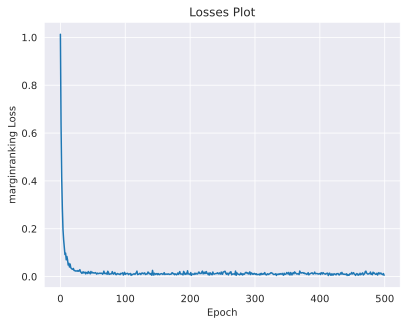

In [ ]:
transe.plot_losses()

In [ ]:
transe.metric_results.to_df()

,Side,Type,Metric,Value
0,head,optimistic,adjusted_geometric_mean_rank_index,0.901915
1,tail,optimistic,adjusted_geometric_mean_rank_index,0.795396
2,both,optimistic,adjusted_geometric_mean_rank_index,0.858222
3,head,realistic,adjusted_geometric_mean_rank_index,0.901915
4,tail,realistic,adjusted_geometric_mean_rank_index,0.795396
...,...,...,...,...
220,tail,realistic,adjusted_hits_at_k,0.078928
221,both,realistic,adjusted_hits_at_k,0.102574
222,head,pessimistic,adjusted_hits_at_k,0.126221
223,tail,pessimistic,adjusted_hits_at_k,0.078928


In [ ]:
transe.save_to_directory("results/transe")

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=2963, num_relations=7, create_inverse_triples=False, num_triples=5264) to file:///content/results/transe/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /content/results/transe


## RotatE

In [ ]:
rotate = pipeline(
    training=training,
    validation=valid,
    testing=testing,
    model="RotatE",
    model_kwargs=dict(embedding_dim=512),
    training_kwargs=dict(use_tqdm_batch=False, num_epochs=500, batch_size=1024),
    evaluation_kwargs=dict(use_tqdm=False),
    negative_sampler_kwargs=dict(num_negs_per_pos=512),
    random_seed=1,
    device="cuda",
)

INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.training.training_loop:Starting sub_batch_size search for training now...
INFO:pykeen.training.training_loop:Concluded search with sub_batch_size 512.


Training epochs on cuda:0:   0%|          | 0/500 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=256.
INFO:pykeen.evaluation.evaluator:Evaluation took 0.27s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

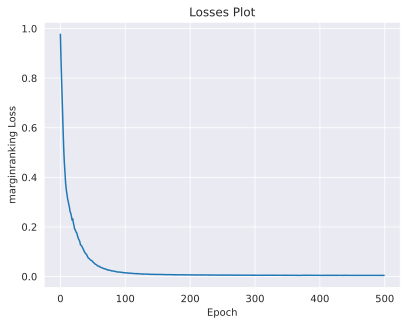

In [ ]:
rotate.plot_losses()

In [ ]:
rotate.metric_results.to_df()

,Side,Type,Metric,Value
0,head,optimistic,adjusted_geometric_mean_rank_index,0.881316
1,tail,optimistic,adjusted_geometric_mean_rank_index,0.833347
2,both,optimistic,adjusted_geometric_mean_rank_index,0.859297
3,head,realistic,adjusted_geometric_mean_rank_index,0.881316
4,tail,realistic,adjusted_geometric_mean_rank_index,0.833347
...,...,...,...,...
220,tail,realistic,adjusted_hits_at_k,0.127726
221,both,realistic,adjusted_hits_at_k,0.142985
222,head,pessimistic,adjusted_hits_at_k,0.158244
223,tail,pessimistic,adjusted_hits_at_k,0.127726


In [ ]:
rotate.save_to_directory("results/rotate")

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=2963, num_relations=7, create_inverse_triples=False, num_triples=5264) to file:///content/results/rotate/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /content/results/rotate
